In [1]:
include("Utils.jl")

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /cache/build/default-amdci4-3/julialang/julia-release-1-dot-8/usr/share/julia/stdlib/v1.8/Pkg/src/Pkg.jl:675
    Updating registry at `/opt/julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/CellularAutomata/StudyNotes/Project.toml`
  No Changes to `~/CellularAutomata/StudyNotes/Manifest.toml`


Main.Utils

In [230]:
@enum BoundaryCondition begin
    ConstantTemperature
    Adiabatic
end

#TODO; weight 是与模型有关的，不用给，边界条件改一下，推广的所有情况。然后把D2Q9完成，输出图像
"""
    LatticeBolzmannMethodD1Q2(tsize, xsize, alpha, weight, initialCondition, boundaryCondition)

# Arguments
- `arrangement::LatticeArrangement`: how lattice are arranged.
- `xsize::Integer`: the number of lattice along x direction start with x = 0 and end with x = xsize.
- `alpha::Float64: the diffusion coefficient in diffusion equation.
- `ysize::Integer=0`: the number of lattice along y direction start with y = 0 and end with y = ysize.
- `zsize::Integer=0`: the number of lattice along z direction start with z = 0 and end with z = zsize.
- `tsize::Integer=100`: the number of lattice along time direction start with t = 0 and end with t = tsize.

"""
function LatticeBolzmannMethodD1Q2(tsize::Integer, xsize::Integer,
        alpha::Float64, weight::Vector{Float64}, initialCondition::Function, boundaryCondition::Function)

    # Pre-check
    D = 1
    @assert sum(weight) == 1.0
    @assert xsize > 0
    @assert length(weight) == 2
    @assert length(initialCondition(xsize)) == 2
    @assert length(boundaryCondition(1, 0)) == 1
    @assert length(boundaryCondition(2, 0)) == 1
    # TODO: check all parameter are valid for given arrangement
    
    # non-dimonsionalized scaling and initiate variables
    dx = 1.0
    dt = 1.0
    speed_of_sound_squared = (dx*dx) / (dt*dt)
    @show omega = 1.0 / (((D * alpha) / (dt * speed_of_sound_squared)) + 0.5)
    
    # Initialize data structure by dimensions
    density_data = fill(0.0, tsize, xsize) # store computation result at each time step

    lattice = Array{Any}(undef, xsize)
    for x in 1:xsize
        lattice[x] = initialCondition(x)
    end
    
    # Main loop
    for i in 1:tsize
        # Collision process
        for j in 1:xsize
            lattice_old = copy(lattice[j])
            lattice[j][1] = (1.0 - omega) * lattice_old[1] + omega * (weight[1] * (lattice_old[1] + lattice_old[2]))
            lattice[j][2] = (1.0 - omega) * lattice_old[2] + omega * (weight[2] * (lattice_old[1] + lattice_old[2]))
        end

        # Streaming process
        for j in 1:xsize
            if j == xsize
                # Boundary condition
                lattice[1][1] = 1.0 - lattice[1][2]  # Constant temperature boundary condition, x=0
                lattice[xsize][1] = lattice[xsize-1][1]  # Adiabatic boundary condition, x=L
                lattice[xsize][2] = lattice[xsize-1][2]  # Adiabatic boundary condition, x=L
            else
                lattice[xsize-j+1][1] = lattice[xsize-j][1]  # f1 streaming
                lattice[j][2] = lattice[j+1][2]  # f2 streaming
            end
        end
        
        # Store Result
        # append!(density_data, DataFrame(rho' , Symbol.("rho_" .* string.(0:m))))  
    end
    
    # y = [0.5 * (lattice[x][1] + lattice[x][2]) for x in 1:xsize]
    # plot(1:xsize, y, marker=:circle, markersize=1, xlabel="Index", ylabel="Modified Value", legend=false)
    return [sum(lattice[x]) for x in 1:xsize] # Actuall value at each nodes
end

LatticeBolzmannMethodD1Q2

In [231]:
?LatticeBolzmannMethodD1Q2

search: LatticeBolzmannMethodD1Q2



```
LatticeBolzmannMethodD1Q2(tsize, xsize, alpha, weight, initialCondition, boundaryCondition)
```

# Arguments

  * `arrangement::LatticeArrangement`: how lattice are arranged.
  * `xsize::Integer`: the number of lattice along x direction start with x = 0 and end with x = xsize.
  * `alpha::Float64: the diffusion coefficient in diffusion equation.
  * `ysize::Integer=0`: the number of lattice along y direction start with y = 0 and end with y = ysize.
  * `zsize::Integer=0`: the number of lattice along z direction start with z = 0 and end with z = zsize.
  * `tsize::Integer=100`: the number of lattice along time direction start with t = 0 and end with t = tsize.


omega = 1.0 / ((D * alpha) / (dt * speed_of_sound_squared) + 0.5) = 1.3333333333333333


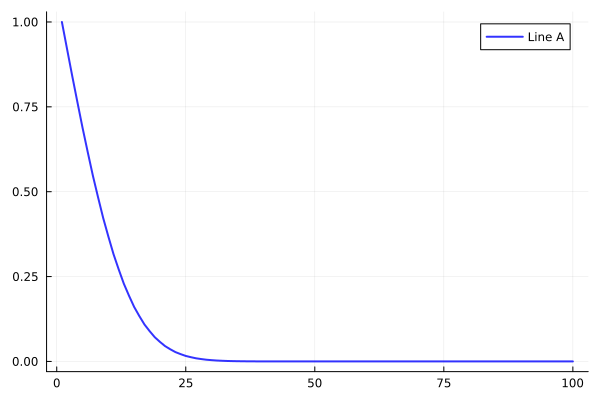

In [228]:
function BC(positionIndex::Integer, counter_position_flux_value)
    if positionIndex == 1 # left
        return 1.0 - counter_position_flux_value
    elseif positionIndex == 2 # right
        return 0
    end
end

t = 200
A = LatticeBolzmannMethodD1Q2(t, 100, 0.25, [0.5, 0.5], x -> [0.0, 0.0], BC);

xinf=1
xsup=100
plot(xinf:xsup, A[xinf:xsup], line = (:blue, 2, 0.8), label = "Line A", legend = :topright)